In [122]:
import torch
from os import listdir,scandir
from os.path import join
import torch
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, splev
import numpy as np

def group_data(list_of_dicts):
    n_dicts = len(list_of_dicts)
    result = dict()

    if n_dicts > 0:
        for k,v in list_of_dicts[0].items():
            if k != "singular":
                partial_result = []
                for d in list_of_dicts:
                        partial_result.append(torch.tensor(d[k]))
                all_metric_data = torch.stack(partial_result)
                mu = torch.mean(all_metric_data, dim=0)
                sigma = torch.std(all_metric_data, dim=0)
                result[k] = mu
                result[f"{k}_std"] = sigma
                    
        return result
    else:
        return None

def group_max_data(list_of_dicts):
    n_dicts = len(list_of_dicts)
    result = dict()

    if n_dicts > 0:
        for k,v in list_of_dicts[0].items():
            if k != "singular":
                partial_result = []
                for d in list_of_dicts:
                        partial_result.append(torch.tensor(d[k]))
                all_metric_data = torch.stack(partial_result)
                mu = torch.max(all_metric_data, dim=1)[0]
                sigma = torch.std(mu, dim=0)
                mu = mu.mean()
                result[k] = mu
                result[f"{k}_std"] = sigma
                    
        return result
    else:
        return None

def flatten_dict(dictionary):
    # task_env1 and eval
    result = dict()
    for k, v in dictionary['task_env1'].items():
        if len(v) > 0:
            result[k.replace("val","ac").replace("test","val")] = v
    for k, v in dictionary['eval'].items():
        if len(v) > 0:
            result[k] = v
    return result
    
def get_data(files, method,dataset,spur):
    result = []
    for k, v in files.items():
        read_method = "_".join(k.split("_")[5:])

        if method == read_method and dataset in k and str(spur) in k:
            result.append(v)
    return result


def plot_metric(f_result, dataset, metric, methods,smooth=0):
    fig, ax = plt.subplots(1, len(spurs),figsize=(36, 3), constrained_layout=False,sharey="row")
    for i, spur in enumerate(spurs):
        for method in methods:
            y = f_result[method][dataset][spur][metric]
            x = list(range(len(y)))
            n = len(x)
            # Compute the B-spline representation of 1-D data
            tck = splrep(x, y, s=smooth)
            # Define new x values for the spline plot
            x_spline = torch.from_numpy(np.linspace(min(x), max(x), n))
            # Evaluate the spline at the new x values
            y_spline = torch.from_numpy(splev(x_spline, tck))
            std = f_result[method][dataset][spur][metric+"_std"]
            ax[i].plot(x_spline,y_spline,label=f"{method}")
            ax[i].fill_between(x, y_spline - std, y_spline + std, alpha=0.2)
            ax[i].legend()
            ax[i].set_title(f"Correlation: {spur}-{metric.capitalize()} vs iterations")


def create_table(results, datasets):
    table_result =  {'method': [], 'dataset': [], 'spur': []
                     , 'val_acc': [], 'val_worst_group_acc': []
                     , 'val_acc_std': [], 'val_worst_group_acc_std': []}
    # Create dictionary for pandas
    for method, values in results.items():
        for dataset in datasets:
            for spur in results[method][dataset].keys():
                table_result['method'].append(method)
                table_result['dataset'].append(dataset)
                table_result['spur'].append(spur)
                if results[method][dataset][spur] is None:
                    table_result['val_acc'].append(-100)
                    table_result['val_acc_std'].append(-100)
                    table_result['val_worst_group_acc'].append(-100)
                    table_result['val_worst_group_acc_std'].append(-100)
                else:
                    table_result['val_acc'].append(100*results[method][dataset][spur]['val_acc'].item())
                    table_result['val_worst_group_acc'].append(100*results[method][dataset][spur]['val_worst_group_acc'].item())
                    table_result['val_acc_std'].append(100*results[method][dataset][spur]['val_acc_std'].item())
                    table_result['val_worst_group_acc_std'].append(100*results[method][dataset][spur]['val_worst_group_acc_std'].item())
    df = pd.DataFrame.from_dict(table_result)
    # Define a formatting function for the 'Salary' column
    def format_perc(perc):
        return '{:.2f}\%'.format(perc)
    def format_float(perc):
        return '{:.2f}'.format(perc)
    
    # Apply the formatting function to the 'Salary' column
    df['val_acc'] = df['val_acc'].apply(format_perc)
    df['val_worst_group_acc'] = df['val_worst_group_acc'].apply(format_perc)
    df['val_acc_std'] = df['val_acc_std'].apply(format_float)
    df['val_worst_group_acc_std'] = df['val_worst_group_acc_std'].apply(format_float)

    return df

In [123]:

results_folder = "stats" # Where to get stats from
def get_file_list(results_folder, methods = []):
    # Get all datafiles
    file_list =[f.path for f in scandir(results_folder)]
    result = []
    for f in file_list:
        for m in methods:
            read_method = "_".join(f.split("_")[5:])
            if m == read_method:
                result.append(f)
    return result
    

def open_files(file_list):
    file_content = dict()
    for f in file_list:
        if f!=".ipynb_checkpoints":
            a  = torch.load(f)
            a = flatten_dict(a)
            file_content[f] = a
    return file_content


def get_raw_results(file_content, methods, datasets, spurs):
    result = dict()
    for method in methods:
        result[method] = dict()
        for dataset in datasets:
            result[method][dataset] = dict()
            for spur in spurs:
                data = get_data(file_content, method,dataset,spur)
                result[method][dataset][spur] = data

    return result
    
def process_results(methods, datasets, spurs, results_folder=""):

    file_list = get_file_list(results_folder, methods)
    file_content = open_files(file_list)
    # Group by method-dataset-correlation
    result = get_raw_results(file_content, methods, datasets, spurs)
    
    # Get mean and stdevs of data
    f_result = dict()
    f_table_result = dict()
    for method in methods:
        f_result[method] = dict()
        f_table_result[method] = dict()
        for dataset in datasets:
            f_result[method][dataset] = dict()
            f_table_result[method][dataset] = dict()
            for spur in [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]:
                f_result[method][dataset][spur] = group_data(result[method][dataset][spur])
                f_table_result[method][dataset][spur] = group_max_data(result[method][dataset][spur])
    return f_result, f_table_result


def add_group_label(method):
    no = "$\\times$"
    yes = "$\surd$"
    if method == "ERM":
        return no
    if method == "JTT":
        return no
    if method == "GDRO":
        return yes
    if method == "RW":
        return yes
    if method == "DFR":
        return no
    if method == "SVDROP":
        return no
def val_batch(method):
    no = "$\\times$"
    yes = "$\surd$"
    if method == "ERM":
        return no
    if method == "JTT":
        return no
    if method == "GDRO":
        return no
    if method == "DFR":
        return yes
    if method == "RW":
        return no
    if method == "SVDROP":
        return no

## Load Results

In [6]:
datasets = ['mnistcifar']
spurs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]

methods = ["svdrop_0.0","svdrop_0.1","svdrop_0.2","svdrop_0.3","svdrop_0.4","svdrop_0.5"]
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"svdrop1_series_results.pth")
torch.save(all_table_results,"svdrop1_table_results.pth")
print("SVDROP saved!")
methods =  ["svdrop_0.6","svdrop_0.7","svdrop_0.8","svdrop_0.9","svdrop_1.0"]
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"svdrop2_series_results.pth")
torch.save(all_table_results,"svdrop2_table_results.pth")
print("SVDROP saved!")
methods = ["jtt250_5","jtt250_10","jtt250_15","jtt250_20"]
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"jtt1_series_results.pth")
torch.save(all_table_results,"jtt1_table_results.pth")
print("JTT saved!")
methods =             [ "jtt50_5","jtt50_10","jtt50_15","jtt50_20"]
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"jtt2_series_results.pth")
torch.save(all_table_results,"jtt2_table_results.pth")
print("JTT saved!")
methods =           ["jtt100_5","jtt100_10","jtt100_15","jtt100_20"]
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"jtt3_series_results.pth")
torch.save(all_table_results,"jtt3_table_results.pth")
print("JTT saved!")
methods =          [   "jtt150_5","jtt150_10","jtt150_15","jtt150_20"]
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"jtt4_series_results.pth")
torch.save(all_table_results,"jtt4_table_results.pth")
print("JTT saved!")
methods =          [  "jtt200_5","jtt200_10","jtt200_15","jtt200_20"]
          
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"jtt5_series_results.pth")
torch.save(all_table_results,"jtt5_table_results.pth")
print("JTT saved!")

SVDROP saved!
SVDROP saved!
JTT saved!
JTT saved!
JTT saved!
JTT saved!
JTT saved!


In [ ]:
methods = ["rw","imgnet_FT", "erm","gdro"]
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"baselines_series_results.pth")
torch.save(all_table_results,"baselines_table_results.pth")
print("Baselines saved!")
methods = ["erm_ft_10","erm_ft_50","erm_ft_100","erm_ft_200","erm_ft_500","erm_ft_1000"]
all_results, all_table_results = process_results(methods, datasets, spurs, results_folder=results_folder)
torch.save(all_results,"dfr_series_results.pth")
torch.save(all_table_results,"dfr_table_results.pth")
print("DFR saved!")

## Calculate Plots

In [124]:
all_results = torch.load("baselines_series_results.pth")
all_table_results = torch.load("baselines_table_results.pth")
datasets = ['mnistcifar']
spurs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]
filenames1 = ["dfr_series_results.pth"
              ,"svdrop1_series_results.pth"
              ,"svdrop2_series_results.pth"
              ,"jtt1_series_results.pth"
              , "jtt2_series_results.pth"
              , "jtt3_series_results.pth"
              , "jtt4_series_results.pth" 
              ,"jtt5_series_results.pth"]
filenames2 = ["dfr_table_results.pth"
              ,"svdrop1_table_results.pth"
              ,"svdrop2_table_results.pth"
              ,"jtt1_table_results.pth"
              , "jtt2_table_results.pth"
              , "jtt3_table_results.pth"
              , "jtt4_table_results.pth" 
              ,"jtt5_table_results.pth"]

total_table = create_table(all_table_results, datasets)
for f1, f2 in zip(filenames1, filenames2):
    new_table = create_table(torch.load(f2),datasets)
    total_table = pd.concat([total_table,new_table], axis=0)

In [125]:
total_table['acc_std'] = total_table['val_acc'].astype("str") + " \pm " + total_table['val_acc_std'].astype("str")
total_table['worst_acc_std'] = total_table['val_worst_group_acc'].astype("str") + " \pm " + total_table['val_worst_group_acc_std'].astype("str")

In [126]:
total_table[total_table['spur'] == 0.9]

method     dataset  spur  val_acc val_worst_group_acc val_acc_std  \
4            rw  mnistcifar   0.9  88.69\%             84.82\%        0.73   
10    imgnet_FT  mnistcifar   0.9  50.33\%             45.60\%        0.71   
16          erm  mnistcifar   0.9  79.88\%             58.75\%        0.82   
22         gdro  mnistcifar   0.9  79.65\%             58.40\%        0.63   
4     erm_ft_10  mnistcifar   0.9  84.82\%             76.50\%        2.35   
10    erm_ft_50  mnistcifar   0.9  86.63\%             78.56\%        1.10   
16   erm_ft_100  mnistcifar   0.9  86.30\%             75.44\%        1.24   
22   erm_ft_200  mnistcifar   0.9  87.05\%             77.57\%        2.09   
28   erm_ft_500  mnistcifar   0.9  87.25\%             78.62\%        1.36   
34  erm_ft_1000  mnistcifar   0.9  87.10\%             79.72\%        1.17   
4    svdrop_0.0  mnistcifar   0.9  80.57\%             60.59\%        0.83   
10   svdrop_0.1  mnistcifar   0.9  80.11\%             64.32\%        1.52   
16   svdrop_0.2  mnistcifar   0.9  78.27\%             60.53\%        0.95   
22   svdrop_0.3  mnistcifar   0.9  76.06\%             60.42\%        1.48   
28   svdrop_0.4  mnistcifar   0.9  75.15\%             59.37\%        1.42   
34   svdrop_0.5  mnistcifar   0.9  74.32\%             60.66\%        1.49   
4    svdrop_0.6  mnistcifar   0.9  75.37\%             60.36\%        1.83   
10   svdrop_0.7  mnistcifar   0.9  75.63\%             61.69\%        2.18   
16   svdrop_0.8  mnistcifar   0.9  74.31\%             61.71\%        1.25   
22   svdrop_0.9  mnistcifar   0.9  81.48\%             70.68\%        8.83   
28   svdrop_1.0  mnistcifar   0.9  74.16\%             61.26\%        2.14   
4      jtt250_5  mnistcifar   0.9  79.67\%             58.99\%        0.47   
10    jtt250_10  mnistcifar   0.9  80.67\%             60.94\%        0.47   
16    jtt250_15  mnistcifar   0.9  80.43\%             59.63\%        0.72   
22    jtt250_20  mnistcifar   0.9  80.77\%             60.04\%        0.61   
4       jtt50_5  mnistcifar   0.9  79.77\%             59.11\%        0.93   
10     jtt50_10  mnistcifar   0.9  80.37\%             60.56\%        0.55   
16     jtt50_15  mnistcifar   0.9  80.73\%             60.94\%        0.60   
22     jtt50_20  mnistcifar   0.9  81.20\%             62.51\%        0.35   
4      jtt100_5  mnistcifar   0.9  79.70\%             59.37\%        0.44   
10    jtt100_10  mnistcifar   0.9  80.73\%             61.22\%        0.12   
16    jtt100_15  mnistcifar   0.9  80.97\%             61.22\%        0.67   
22    jtt100_20  mnistcifar   0.9  80.63\%             61.07\%        0.25   
4      jtt150_5  mnistcifar   0.9  80.07\%             59.90\%        0.67   
10    jtt150_10  mnistcifar   0.9  80.43\%             60.03\%        0.78   
16    jtt150_15  mnistcifar   0.9  80.47\%             60.94\%        0.55   
22    jtt150_20  mnistcifar   0.9  81.00\%             60.96\%        0.61   
4      jtt200_5  mnistcifar   0.9  80.37\%             60.04\%        0.47   
10    jtt200_10  mnistcifar   0.9  80.27\%             59.38\%        0.40   
16    jtt200_15  mnistcifar   0.9  80.67\%             60.42\%        0.42   
22    jtt200_20  mnistcifar   0.9  80.97\%             60.55\%        0.40   

   val_worst_group_acc_std           acc_std      worst_acc_std  
4                     1.17  88.69\% \pm 0.73   84.82\% \pm 1.17  
10                    1.08  50.33\% \pm 0.71   45.60\% \pm 1.08  
16                    1.73  79.88\% \pm 0.82   58.75\% \pm 1.73  
22                    1.52  79.65\% \pm 0.63   58.40\% \pm 1.52  
4                     4.66  84.82\% \pm 2.35   76.50\% \pm 4.66  
10                    3.65  86.63\% \pm 1.10   78.56\% \pm 3.65  
16                    4.46  86.30\% \pm 1.24   75.44\% \pm 4.46  
22                    7.44  87.05\% \pm 2.09   77.57\% \pm 7.44  
28                    5.96  87.25\% \pm 1.36   78.62\% \pm 5.96  
34                    4.48  87.10\% \pm 1.17   79.72\% \pm 4.48  
4     

In [61]:
total_pv = total_table.pivot(index='method',columns="spur",values=['acc_std',"worst_acc_std"])

In [9]:
total_pv[total_pv.index.isin(['erm',"erm_ft_100","erm_ft_1000",'rw',"gdro",'svdrop_0.1',"jtt50_20"])]

val_acc                                            \
spur           0.00    0.25    0.50    0.75    0.90      1.00   
method                                                          
erm          94.04%  93.69%  92.06%  88.48%  79.88%    59.20%   
erm_ft_100   92.11%  89.45%  90.31%  88.12%  86.30%    70.34%   
erm_ft_1000  92.24%  91.07%  90.59%  88.46%  87.10%    71.15%   
gdro         93.88%  93.55%  92.15%  88.45%  79.65%    54.45%   
jtt50_20     94.40%  93.77%  92.30%  89.00%  81.20%  -100.00%   
rw           93.88%  93.19%  92.87%  90.84%  88.69%    59.49%   
svdrop_0.1   94.50%  94.53%  93.26%  89.15%  80.11%    66.45%   

            val_worst_group_acc                                            
spur                       0.00    0.25    0.50    0.75    0.90      1.00  
method                                                                     
erm                      93.24%  91.15%  86.16%  77.37%  58.75%    17.63%  
erm_ft_100               90.07%  86.49%  86.05%  79.94%  75.44%    57.90%  
erm_ft_1000              91.04%  88.87%  85.54%  79.88%  79.72%    62.73%  
gdro                     93.08%  90.60%  86.24%  77.60%  58.40%    31.25%  
jtt50_20                 93.74%  91.67%  86.76%  79.68%  62.51%  -100.00%  
rw                       93.22%  92.14%  90.54%  87.56%  84.82%    17.67%  
svdrop_0.1               93.80%  91.88%  88.17%  79.13%  64.32%    46.40%

In [62]:
erm = pd.DataFrame(total_pv[total_pv.index.isin(['erm'])].max()).reset_index()
erm['method'] = "ERM" # Best results for ERM
print(erm)

gdro = pd.DataFrame(total_pv[total_pv.index.isin(['gdro'])].max()).reset_index()
gdro['method'] = "GDRO" # Best results for GDRO
print(gdro)

rw = pd.DataFrame(total_pv[total_pv.index.isin(['rw'])].max()).reset_index()
rw['method'] = "RW" # Best results for RW
print(rw)

svdrop = pd.DataFrame(total_pv[total_pv.index.isin(['svdrop_0.1','svdrop_0.2','svdrop_0.3','svdrop_0.4','svdrop_0.5','svdrop_0.6','svdrop_0.7','svdrop_0.8','svdrop_0.9'])].max()).reset_index()
svdrop['method'] = "SVDROP" # Best results for SVDROP
print(svdrop)

dfr = pd.DataFrame(total_pv[total_pv.index.isin(["erm_ft_10","erm_ft_50","erm_ft_100","erm_ft_200","erm_ft_500","erm_ft_1000"])].max()).reset_index()
dfr['method'] = "DFR" # Best results for DFR
print(dfr)

jtt = pd.DataFrame(total_pv[total_pv.index.isin(["jtt200_20","jtt250_20","jtt100_10","jtt150_15","jtt50_20"])].max()).reset_index() # Best results for JTT
jtt['method'] = "JTT" # Best results for JTT
print(jtt)

all_data  = pd.concat([erm,rw,gdro,dfr,jtt,svdrop],axis=0)

          level_0  spur                  0 method
0         acc_std  0.00   94.04\% \pm 0.40    ERM
1         acc_std  0.25   93.69\% \pm 0.50    ERM
2         acc_std  0.50   92.06\% \pm 0.55    ERM
3         acc_std  0.75   88.48\% \pm 0.68    ERM
4         acc_std  0.90   79.88\% \pm 0.82    ERM
5         acc_std  1.00   59.20\% \pm 1.99    ERM
6   worst_acc_std  0.00   93.24\% \pm 0.45    ERM
7   worst_acc_std  0.25   91.15\% \pm 0.52    ERM
8   worst_acc_std  0.50   86.16\% \pm 1.21    ERM
9   worst_acc_std  0.75   77.37\% \pm 1.47    ERM
10  worst_acc_std  0.90   58.75\% \pm 1.73    ERM
11  worst_acc_std  1.00  17.63\% \pm 19.95    ERM
          level_0  spur                  0 method
0         acc_std  0.00   93.88\% \pm 0.47   GDRO
1         acc_std  0.25   93.55\% \pm 0.87   GDRO
2         acc_std  0.50   92.15\% \pm 0.60   GDRO
3         acc_std  0.75   88.45\% \pm 0.34   GDRO
4         acc_std  0.90   79.65\% \pm 0.63   GDRO
5         acc_std  1.00   54.45\% \pm 2.32   GDRO


In [90]:
filter_data = all_data[all_data['level_0'] == "worst_acc_std"]
print(filter_data.columns)
f_pv = filter_data.pivot(index="method", columns="spur", values=0)
a = f_pv.reset_index()
a['group'] = a['method'].apply(add_group_label) # add group information needed label
a['val_batch'] = a['method'].apply(val_batch)   # add requires validation batch for finetuning
a.set_index('method')
print(a.to_latex())

Index(['level_0', 'spur', 0, 'method'], dtype='object')
\begin{tabular}{lllllll}
\toprule
spur & 0.000000 & 0.250000 & 0.500000 & 0.750000 & 0.900000 & 1.000000 \\
method &  &  &  &  &  &  \\
\midrule
DFR & 91.04\% \pm 1.35 & 88.87\% \pm 4.34 & 86.72\% \pm 2.45 & 82.13\% \pm 3.13 & 79.72\% \pm 4.48 & 62.73\% \pm 4.24 \\
ERM & 93.24\% \pm 0.45 & 91.15\% \pm 0.52 & 86.16\% \pm 1.21 & 77.37\% \pm 1.47 & 58.75\% \pm 1.73 & 17.63\% \pm 19.95 \\
GDRO & 93.08\% \pm 0.73 & 90.60\% \pm 0.81 & 86.24\% \pm 1.09 & 77.60\% \pm 0.73 & 58.40\% \pm 1.52 & 31.25\% \pm 23.95 \\
JTT & 94.19\% \pm 0.49 & 92.27\% \pm 0.14 & 87.24\% \pm 0.23 & 79.68\% \pm 0.40 & 62.51\% \pm 1.02 & -100.00\% \pm -100.00 \\
RW & 93.22\% \pm 0.57 & 92.14\% \pm 0.41 & 90.54\% \pm 0.57 & 87.56\% \pm 0.72 & 84.82\% \pm 1.17 & 17.67\% \pm 19.92 \\
SVDROP & 93.80\% \pm 0.53 & 91.88\% \pm 0.44 & 88.17\% \pm 0.51 & 79.13\% \pm 1.68 & 70.68\% \pm 17.10 & 49.00\% \pm 21.20 \\
\bottomrule
\end{tabular}



spur                 0.0              0.25               0.5  \
method                                                         
DFR     91.04\% \pm 1.35  88.87\% \pm 4.34  86.72\% \pm 2.45   
ERM     93.24\% \pm 0.45  91.15\% \pm 0.52  86.16\% \pm 1.21   
GDRO    93.08\% \pm 0.73  90.60\% \pm 0.81  86.24\% \pm 1.09   
JTT     94.19\% \pm 0.49  92.27\% \pm 0.14  87.24\% \pm 0.23   
RW      93.22\% \pm 0.57  92.14\% \pm 0.41  90.54\% \pm 0.57   
SVDROP  93.80\% \pm 0.53  91.88\% \pm 0.44  88.17\% \pm 0.51   

spur                0.75                0.9                    1.0     group  \
method                                                                         
DFR     82.13\% \pm 3.13   79.72\% \pm 4.48       62.73\% \pm 4.24  $\times$   
ERM     77.37\% \pm 1.47   58.75\% \pm 1.73      17.63\% \pm 19.95  $\times$   
GDRO    77.60\% \pm 0.73   58.40\% \pm 1.52      31.25\% \pm 23.95   $\surd$   
JTT     79.68\% \pm 0.40   62.51\% \pm 1.02  -100.00\% \pm -100.00  $\times$   
RW      87.56\% \pm 0.72   84.82\% \pm 1.17      17.67\% \pm 19.92   $\surd$   
SVDROP  79.13\% \pm 1.68  70.68\% \pm 17.10      49.00\% \pm 21.20  $\times$   

spur   val_batch  
method            
DFR      $\surd$  
ERM     $\times$  
GDRO    $\times$  
JTT     $\times$  
RW      $\times$  
SVDROP  $\times$

## Methods vs each other

### Baselines: ERM, RW, GDRO, IMGNET_ERM

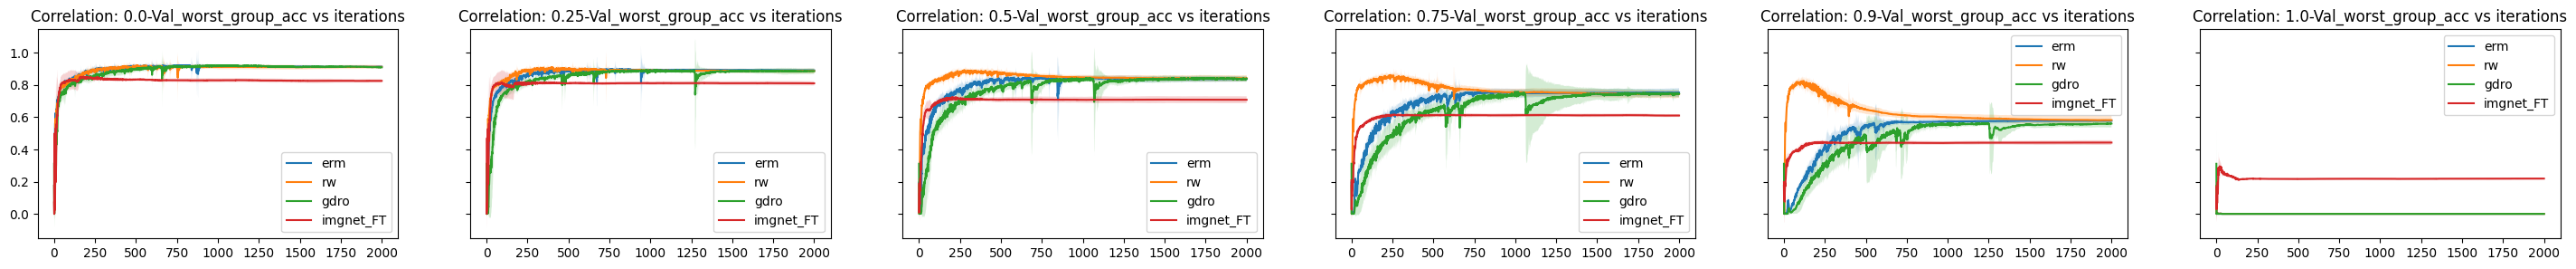

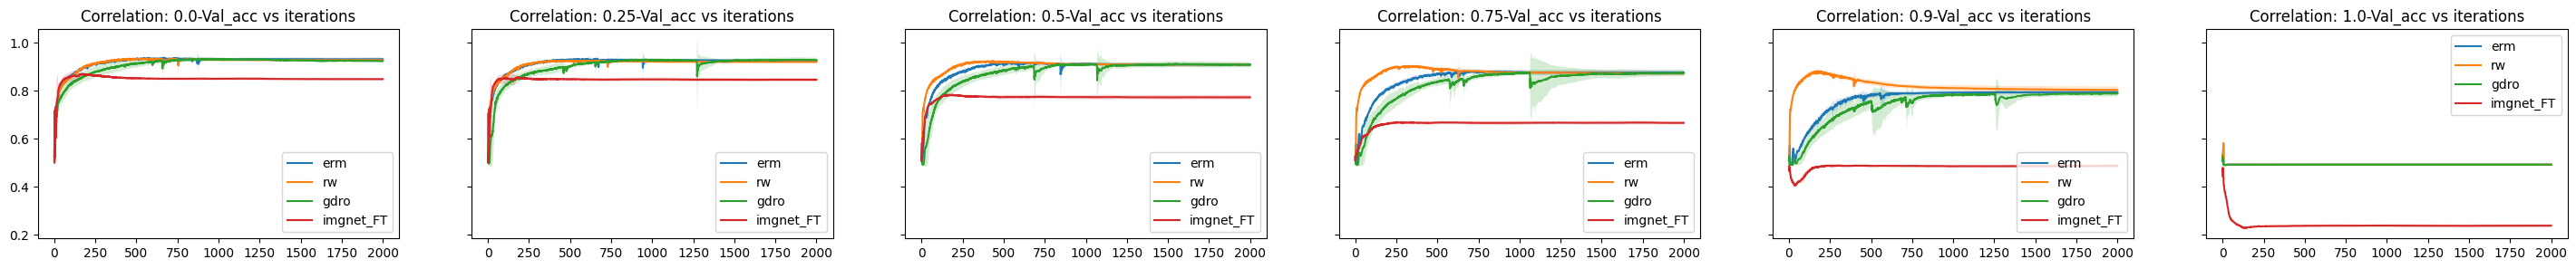

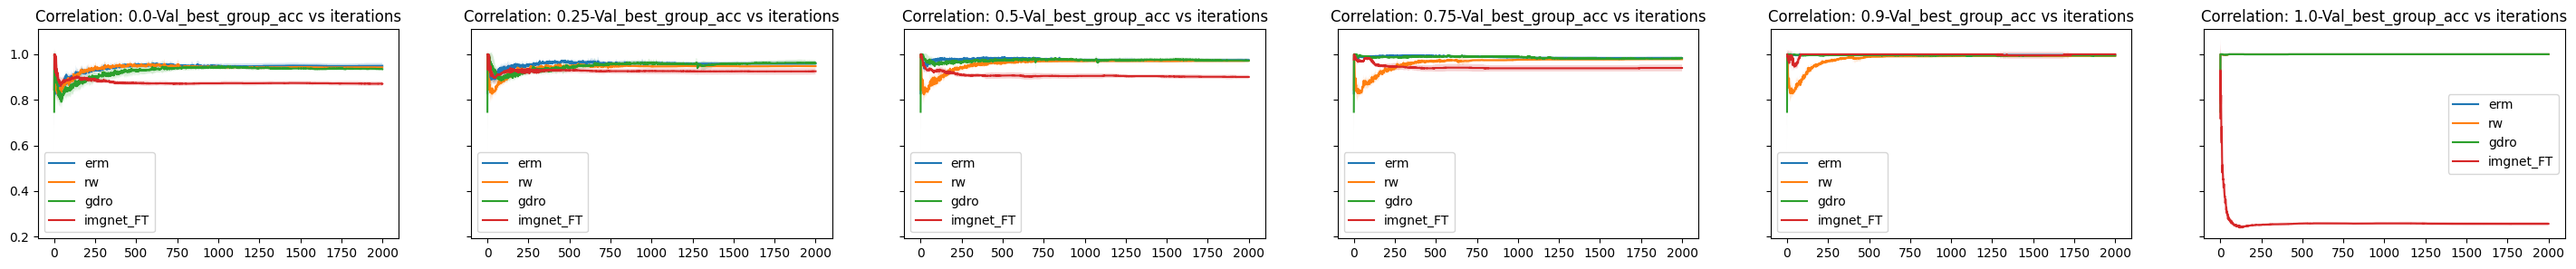

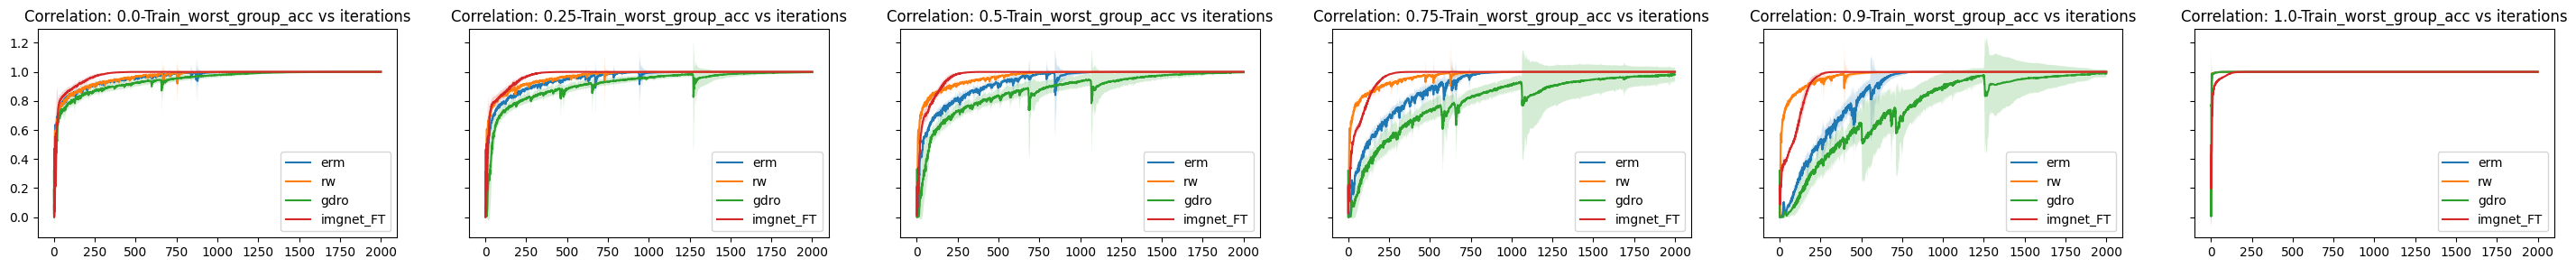

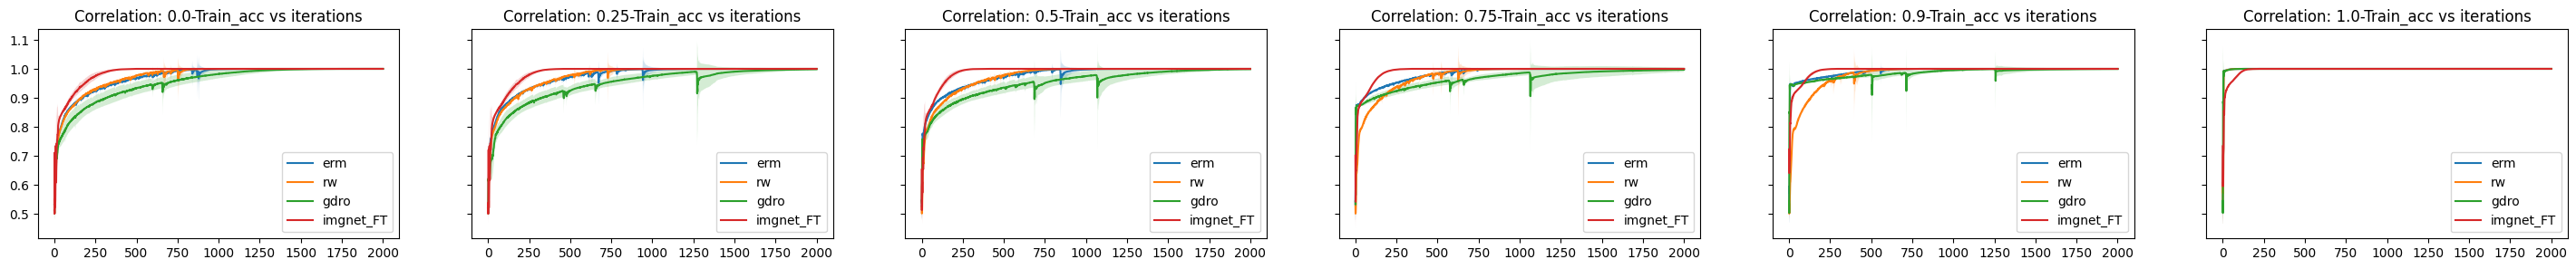

In [34]:
spurs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]
methods = ['erm','rw','gdro','imgnet_FT']
metrics = ['val_worst_group_acc','val_acc','val_best_group_acc','train_worst_group_acc','train_acc']
for metric in metrics:
    plot_metric(all_results, "mnistcifar", metric, methods)

### DFR

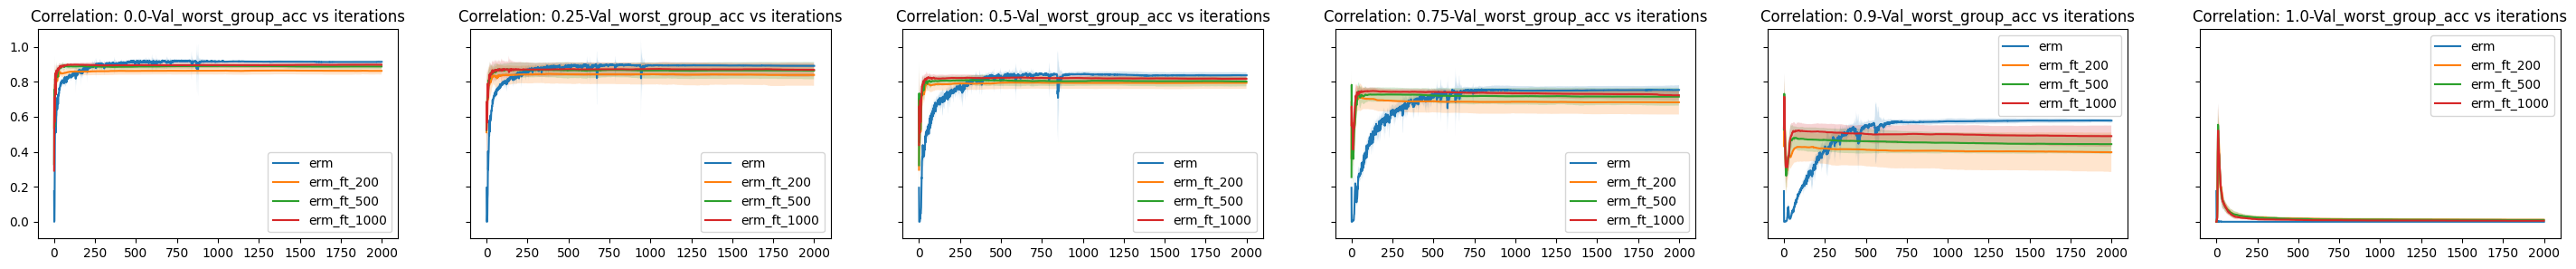

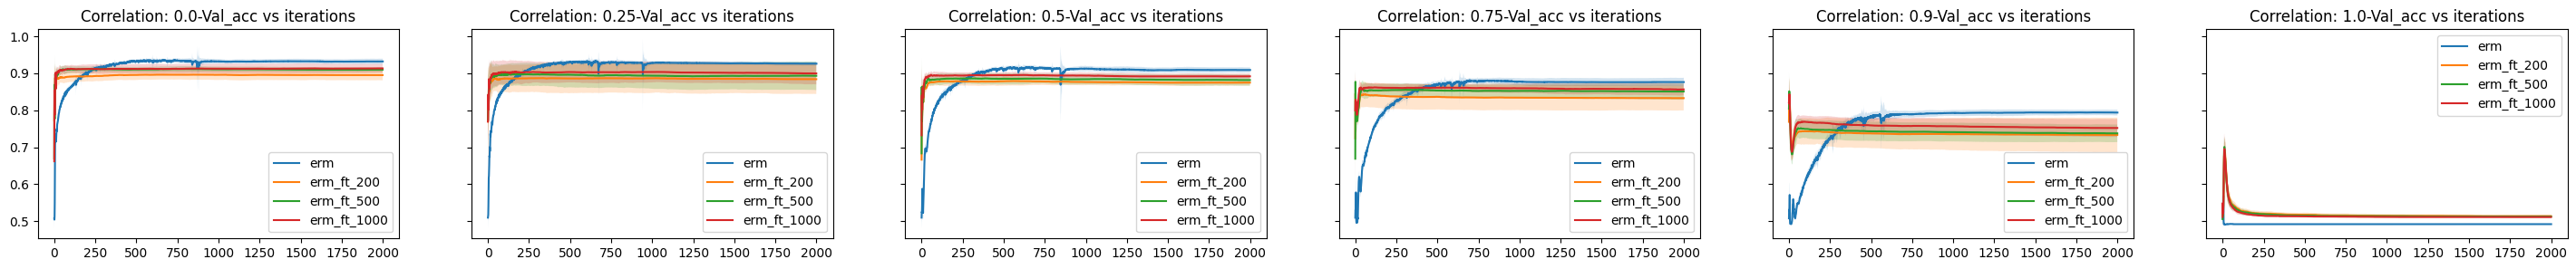

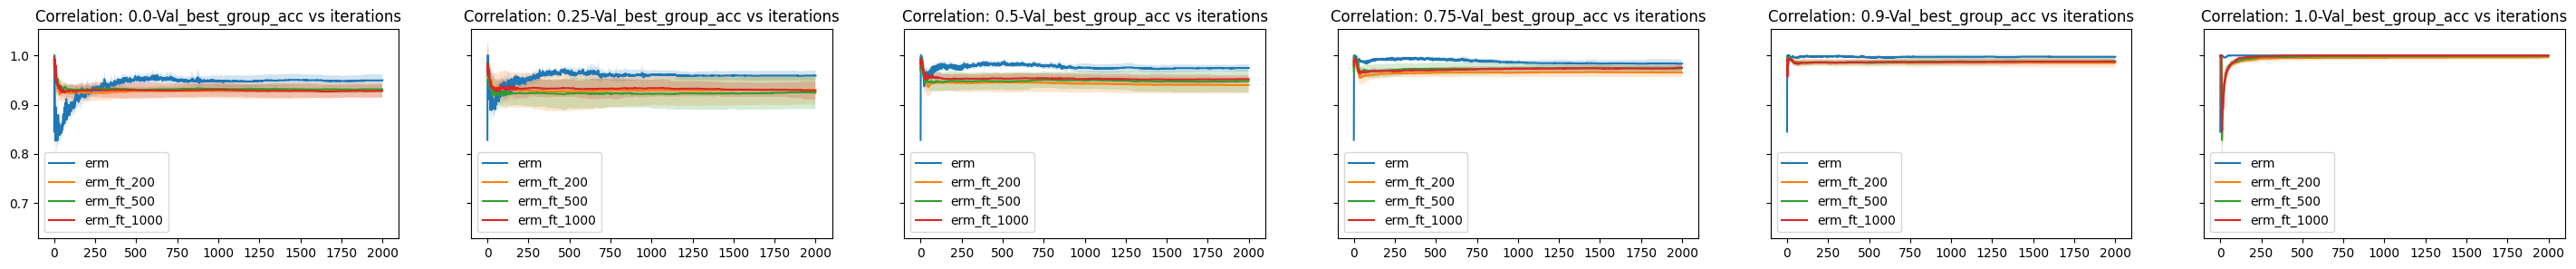

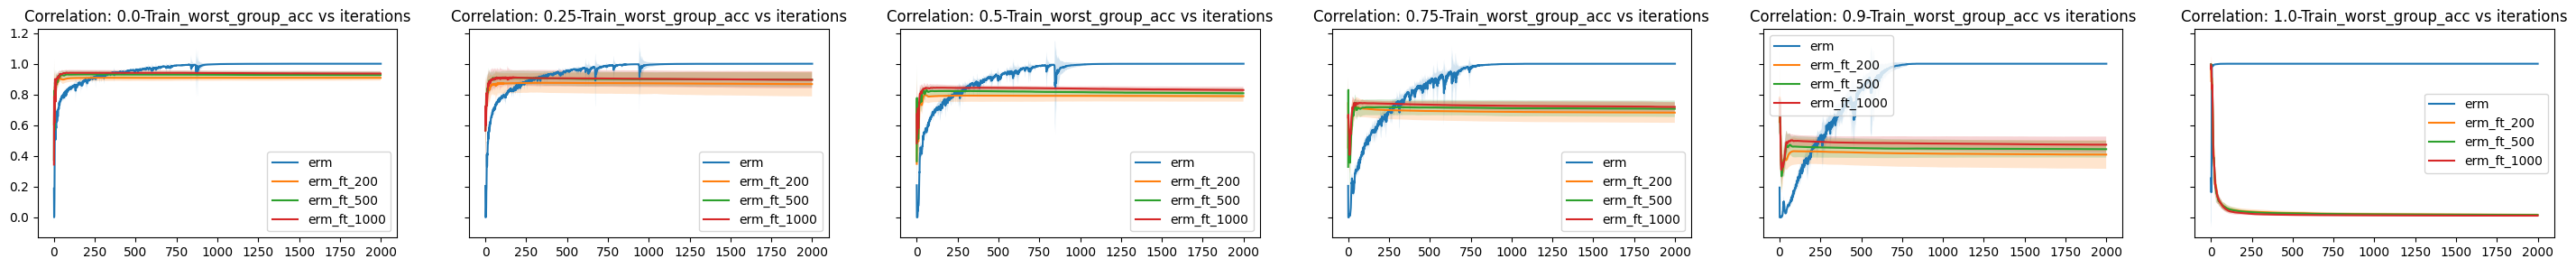

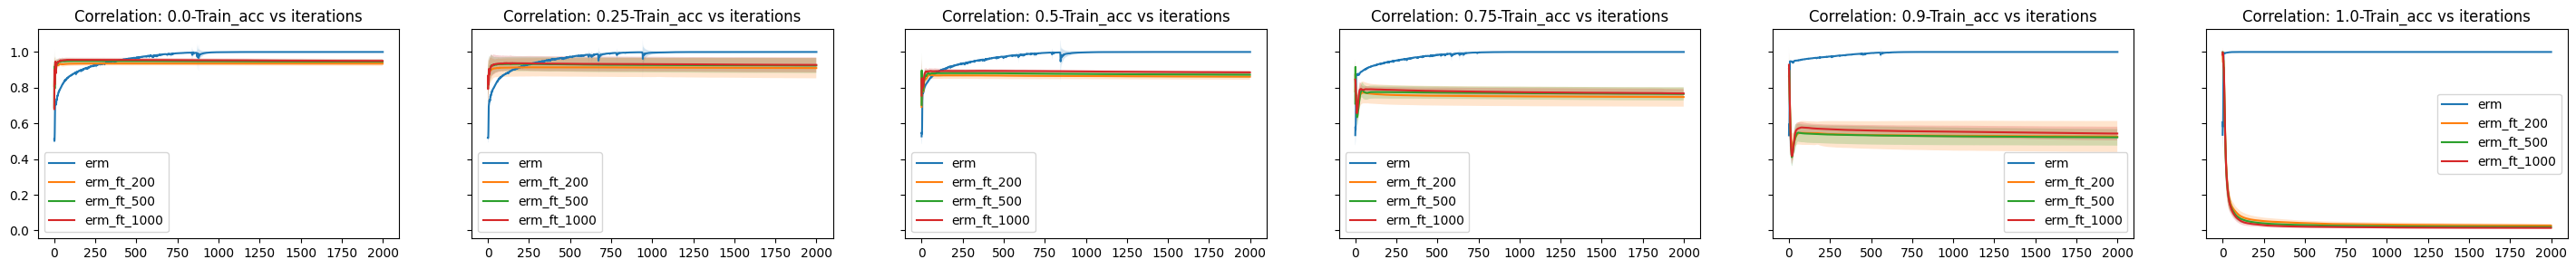

In [35]:
methods = ['erm',"erm_ft_200","erm_ft_500","erm_ft_1000"]
metrics = ['val_worst_group_acc','val_acc','val_best_group_acc','train_worst_group_acc','train_acc']
for metric in metrics:
    plot_metric(all_results, "mnistcifar", metric, methods)

### SVDROP

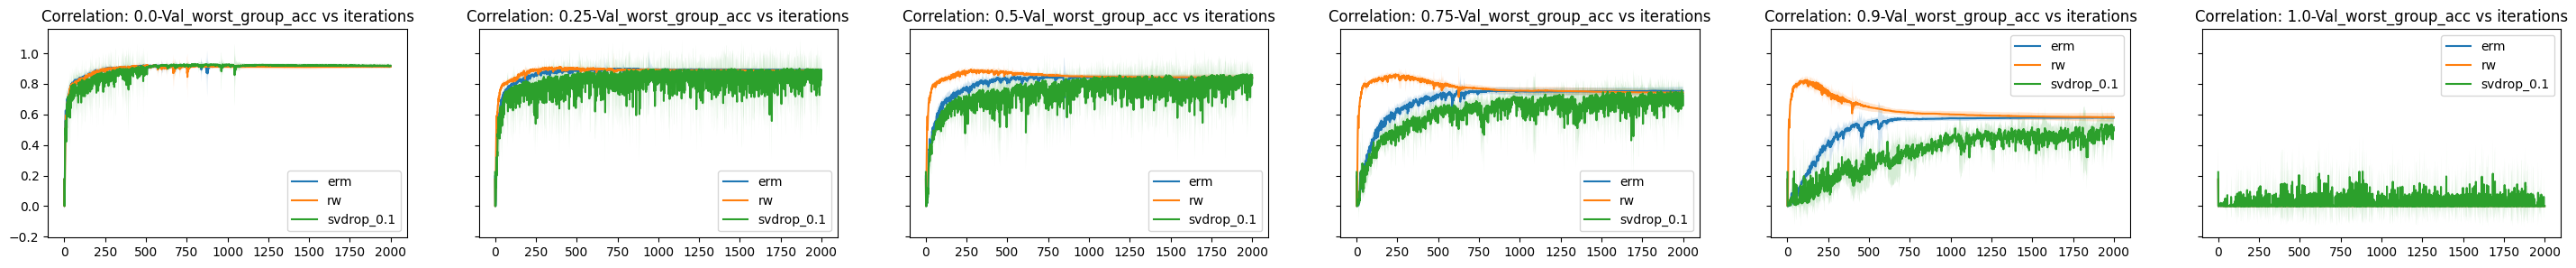

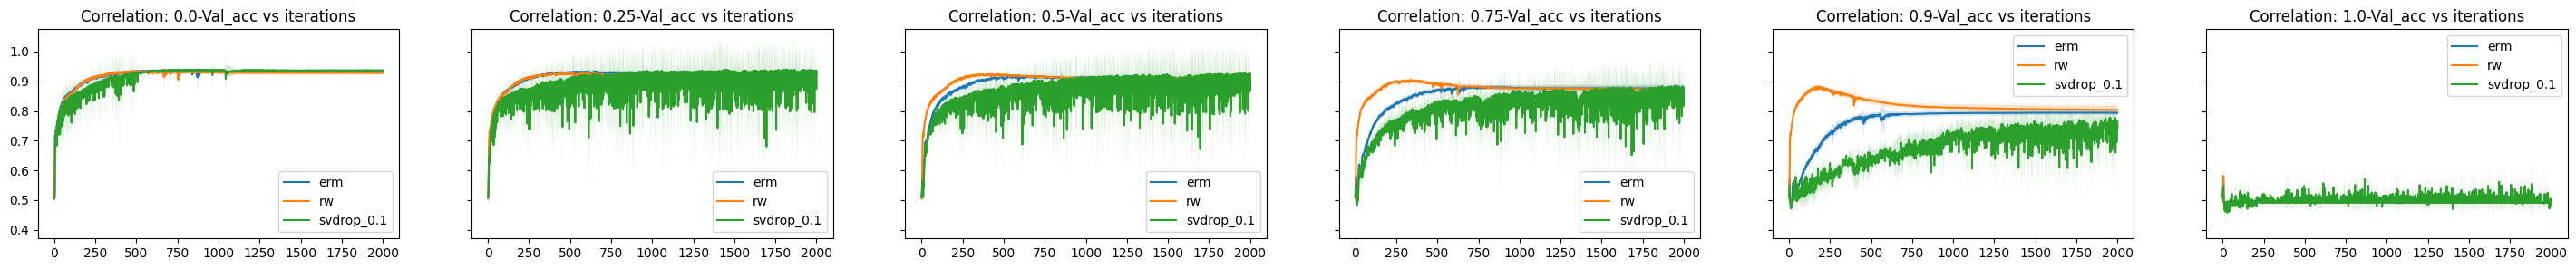

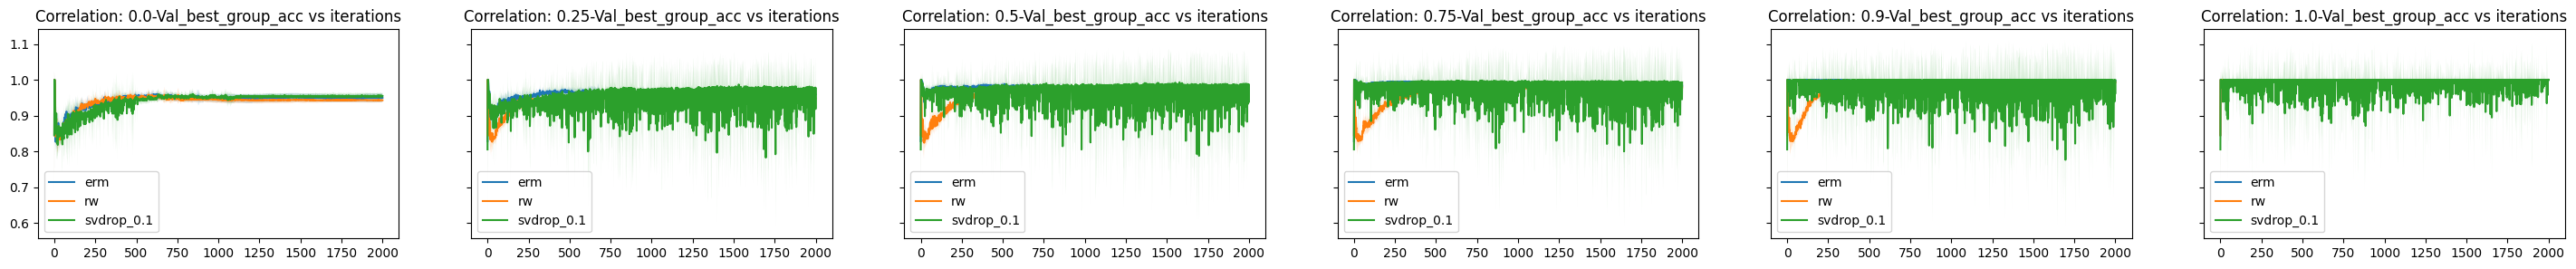

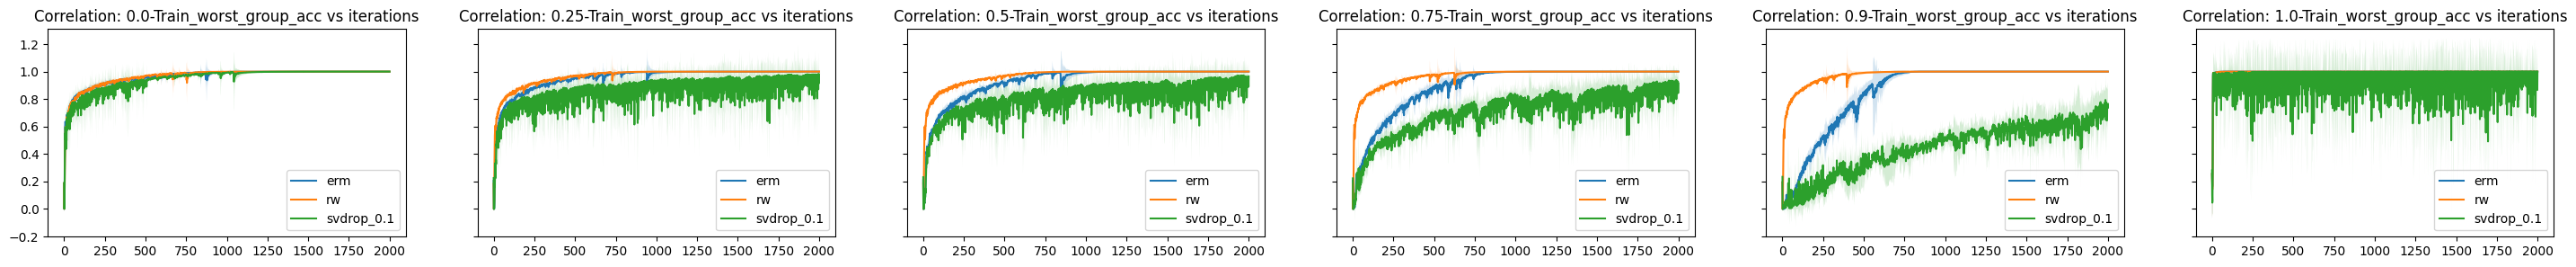

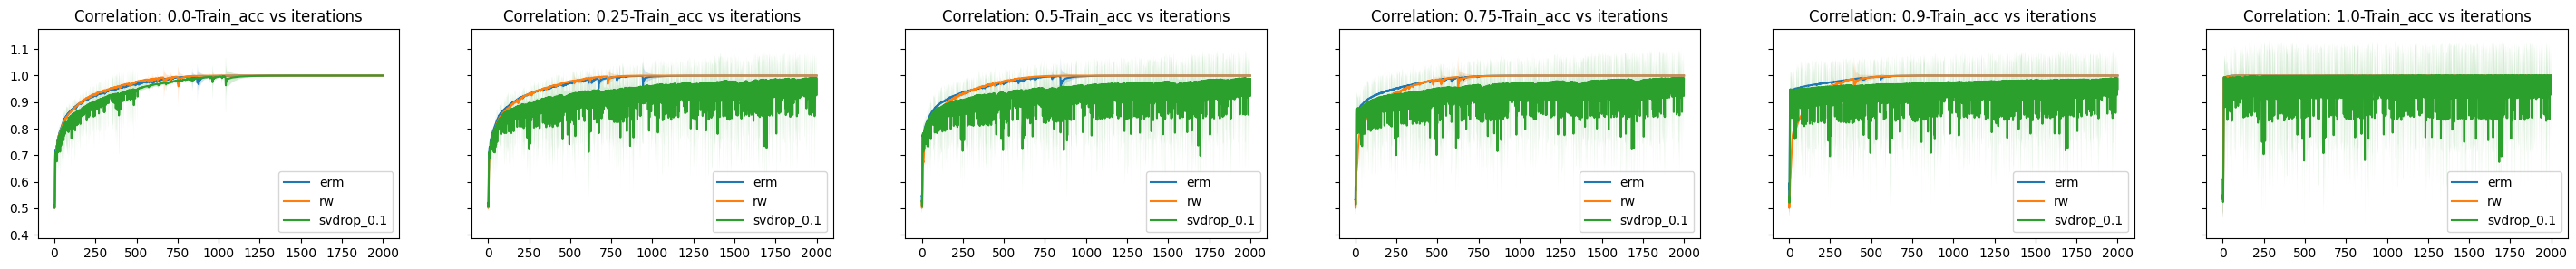

In [6]:
methods = ["erm", "rw","svdrop_0.1"]
metrics = ['val_worst_group_acc','val_acc','val_best_group_acc','train_worst_group_acc','train_acc']
for metric in metrics:
    plot_metric(all_results, "mnistcifar", metric, methods,smooth=0)

# Results Table

## Imagenet pretraining: does it help against Spurious Correlations?

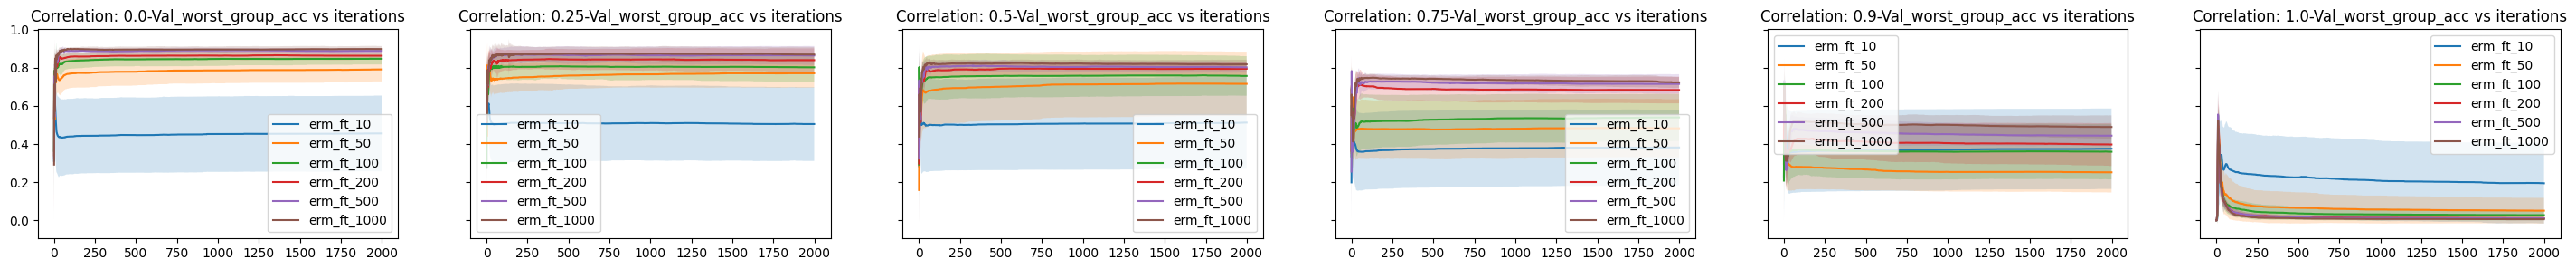

In [46]:
spurs = [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]
plot_metric(results, "mnistcifar", 'val_worst_group_acc')

In [58]:
dfr.groupby(['dataset','spur'])['val_worst_group_acc'].max().reset_index()

dataset  spur val_worst_group_acc
0  mnistcifar  0.00              89.88%
1  mnistcifar  0.25              87.37%
2  mnistcifar  0.50              82.65%
3  mnistcifar  0.75              78.25%
4  mnistcifar  0.90              73.12%
5  mnistcifar  1.00              55.45%

In [68]:
indices = df.groupby(['dataset','spur'])['val_worst_group_acc'].idxmax()
dfr = df.loc[indices]

In [92]:
total = baselines._append(dfr)
def requires_train_labels(method):
    if method in ['gdro','rw']:
        return True
    return False

def requires_test_labels(method):
    if "erm_ft" in method:
        return True
    elif method == "jtt":
        return True
    else:
        return False
total['Labels_in_Train'] = total['method'].apply(requires_train_labels)
total['Labels_in_Test'] = total['method'].apply(requires_test_labels)

### Final Results

In [6]:
total_pv = baselines.pivot(index='method',columns="spur",values=['val_acc',"val_worst_group_acc"])

In [14]:
total_pv[total_pv.index.isin(['erm',"erm_ft_100","erm_ft_1000",'rw',"gdro",'svdrop_0.1'])]

val_acc                                          \
spur           0.00    0.25    0.50    0.75    0.90    1.00   
method                                                        
erm          94.04%  93.69%  92.06%  88.48%  79.88%  59.20%   
erm_ft_100   92.11%  89.45%  90.31%  88.12%  86.30%  70.34%   
erm_ft_1000  92.24%  91.07%  90.59%  88.46%  87.10%  71.15%   
gdro         93.88%  93.55%  92.15%  88.45%  79.65%  54.45%   
rw           93.88%  93.19%  92.87%  90.84%  88.69%  59.49%   
svdrop_0.1   94.50%  94.53%  93.26%  89.15%  80.11%  66.45%   

            val_worst_group_acc                                          
spur                       0.00    0.25    0.50    0.75    0.90    1.00  
method                                                                   
erm                      93.24%  91.15%  86.16%  77.37%  58.75%  17.63%  
erm_ft_100               90.07%  86.49%  86.05%  79.94%  75.44%  57.90%  
erm_ft_1000              91.04%  88.87%  85.54%  79.88%  79.72%  62.73%  
gdro                     93.08%  90.60%  86.24%  77.60%  58.40%  31.25%  
rw                       93.22%  92.14%  90.54%  87.56%  84.82%  17.67%  
svdrop_0.1               93.80%  91.88%  88.17%  79.13%  64.32%  46.40%

In [96]:
total.loc[total.groupby(['dataset','spur'])['val_worst_group_acc'].idxmax()].sort_values(by="Labels_in_Train") # Overall

method     dataset  spur val_acc val_worst_group_acc  Labels_in_Train  \
24  erm_ft_500  mnistcifar  0.00  91.17%              89.26%            False   
1    erm_ft_10  mnistcifar  0.25  82.96%              67.02%            False   
2    erm_ft_10  mnistcifar  0.50  83.47%              63.52%            False   
3    erm_ft_10  mnistcifar  0.75  81.32%              60.24%            False   
4    erm_ft_10  mnistcifar  0.90  79.16%              58.91%            False   
29  erm_ft_500  mnistcifar  1.00  70.11%              55.45%            False   
24        gdro  mnistcifar  0.00  93.30%              92.38%             True   
1           rw  mnistcifar  0.25  92.67%              91.04%             True   
2           rw  mnistcifar  0.50  92.39%              89.18%             True   
3           rw  mnistcifar  0.75  90.38%              86.17%             True   
4           rw  mnistcifar  0.90  88.25%              82.56%             True   
29        gdro  mnistcifar  1.00  51.40%               0.33%             True   

    Labels_in_Test  
24            True  
1             True  
2             True  
3             True  
4             True  
29            True  
24           False  
1            False  
2            False  
3            False  
4            False  
29           False

In [38]:
# Sort within each group and get the first row
baselines.sort_values(by='val_worst_group_acc', ascending=False).groupby(['dataset', 'spur']).first().reset_index()

dataset  spur      method val_acc val_worst_group_acc
0  mnistcifar  0.00  svdrop_0.2  94.73%              94.10%
1  mnistcifar  0.25          rw  93.19%              92.14%
2  mnistcifar  0.50          rw  92.87%              90.54%
3  mnistcifar  0.75          rw  90.84%              87.56%
4  mnistcifar  0.90          rw  88.69%              84.82%
5  mnistcifar  1.00  svdrop_1.0  79.85%              71.86%

In [101]:
total.sort_values(by='val_worst_group_acc', ascending=False).groupby(['dataset', 'spur','Labels_in_Train']).first().reset_index().sort_values(by="Labels_in_Train")

dataset  spur  Labels_in_Train      method val_acc val_worst_group_acc  \
0   mnistcifar  0.00            False         erm  93.57%              92.22%   
2   mnistcifar  0.25            False         erm  93.37%              90.06%   
4   mnistcifar  0.50            False         erm  91.67%              84.92%   
6   mnistcifar  0.75            False  erm_ft_500  87.71%              78.25%   
8   mnistcifar  0.90            False  erm_ft_500  85.14%              73.12%   
10  mnistcifar  1.00            False  erm_ft_500  70.11%              55.45%   
1   mnistcifar  0.00             True        gdro  93.30%              92.38%   
3   mnistcifar  0.25             True          rw  92.67%              91.04%   
5   mnistcifar  0.50             True          rw  92.39%              89.18%   
7   mnistcifar  0.75             True          rw  90.38%              86.17%   
9   mnistcifar  0.90             True          rw  88.25%              82.56%   
11  mnistcifar  1.00             True          rw  58.19%               0.39%   

    Labels_in_Test  
0            False  
2            False  
4            False  
6             True  
8             True  
10            True  
1            False  
3            False  
5            False  
7            False  
9            False  
11           False

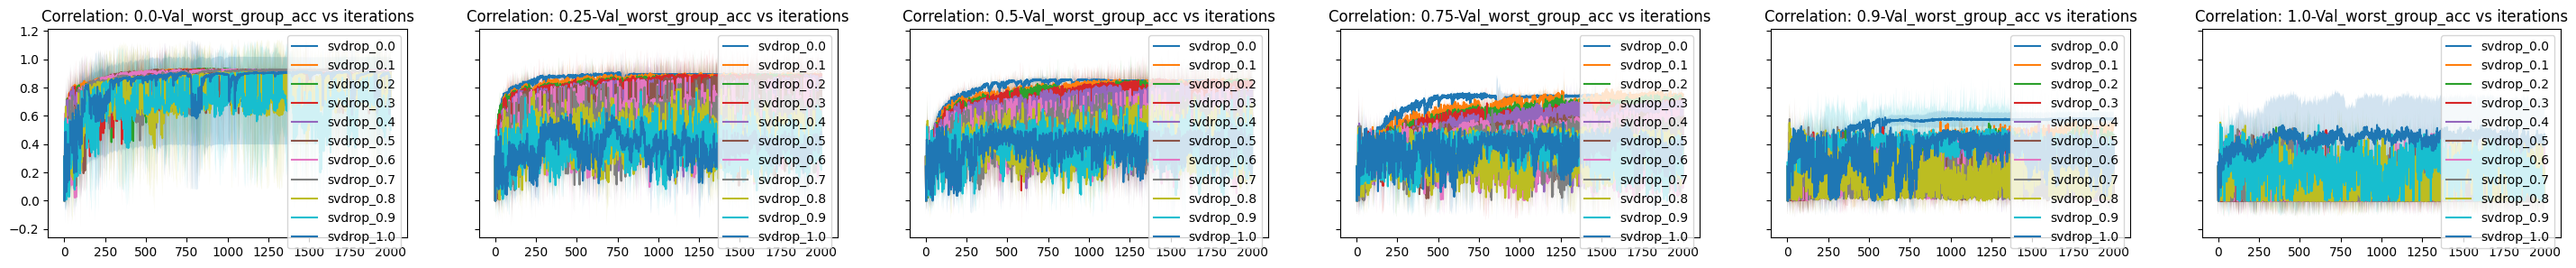

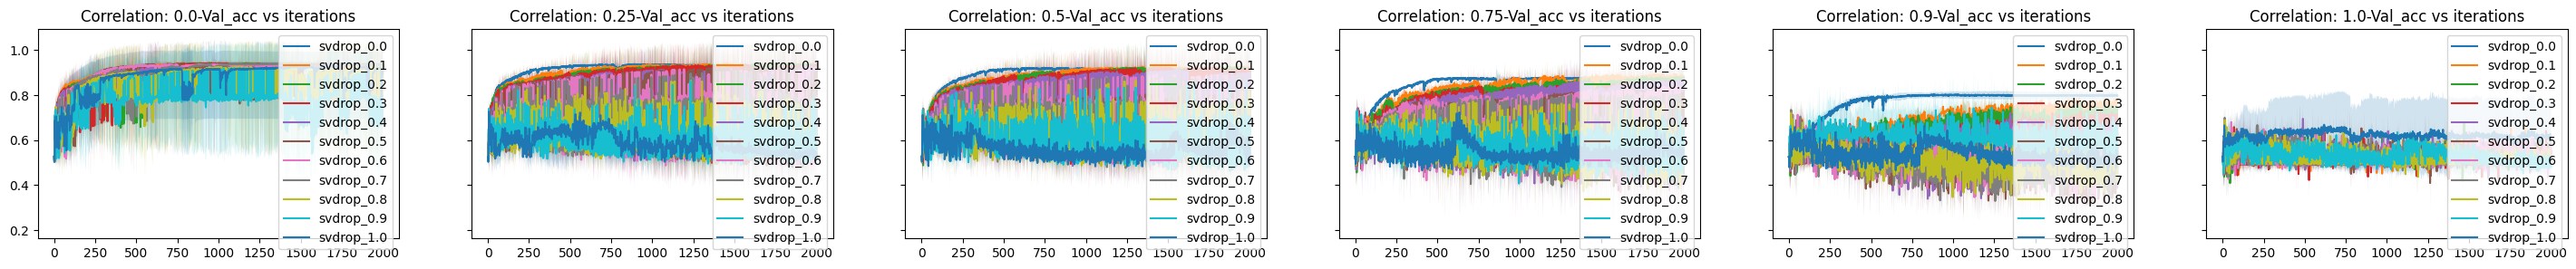

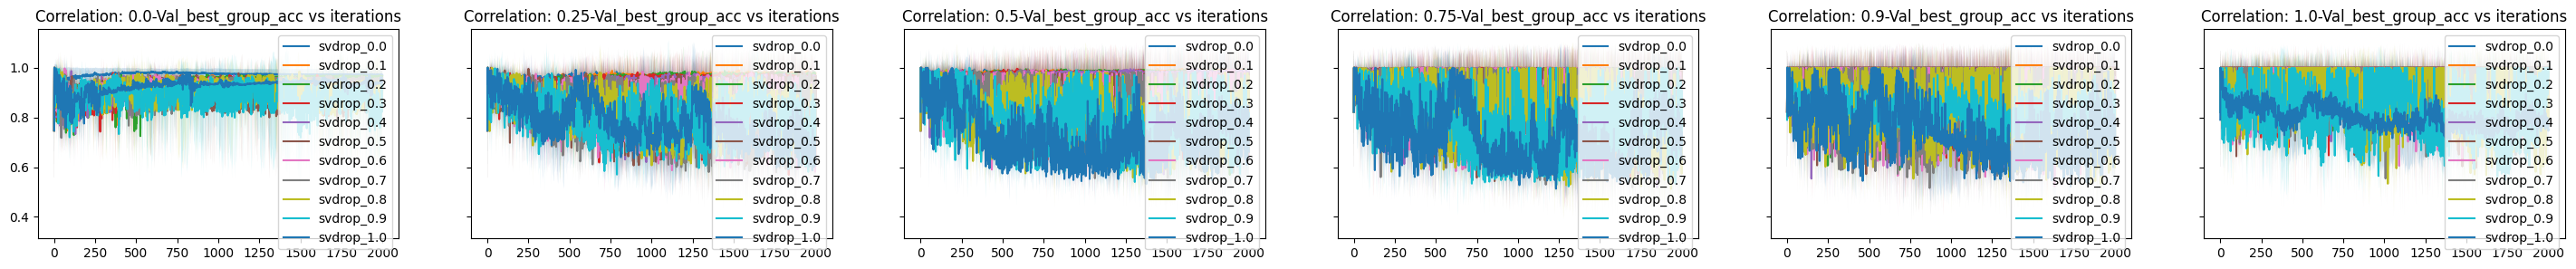

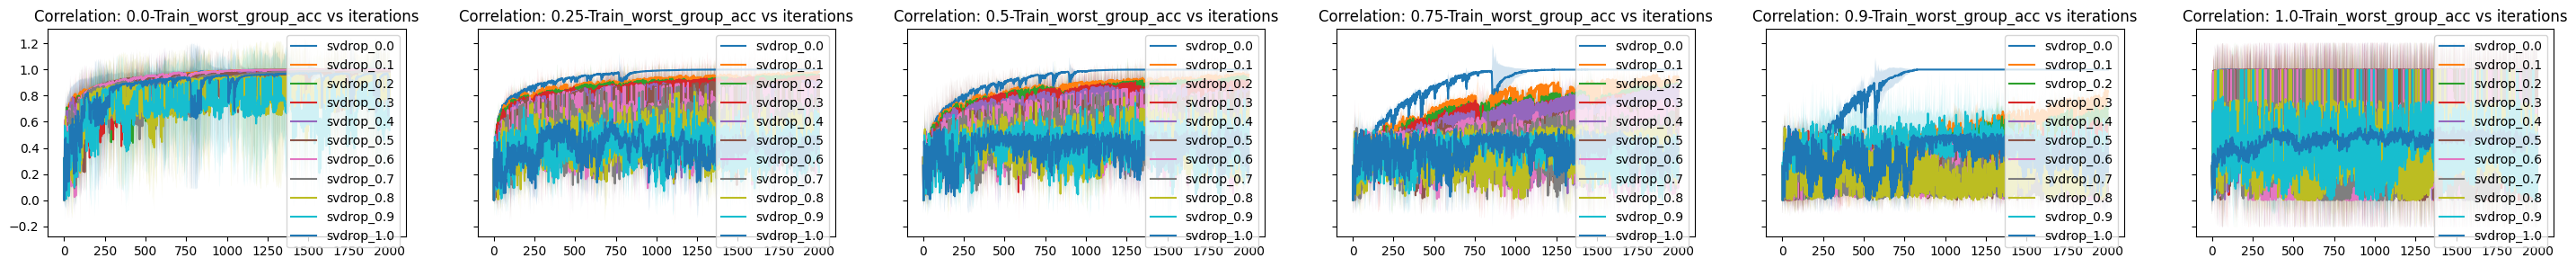

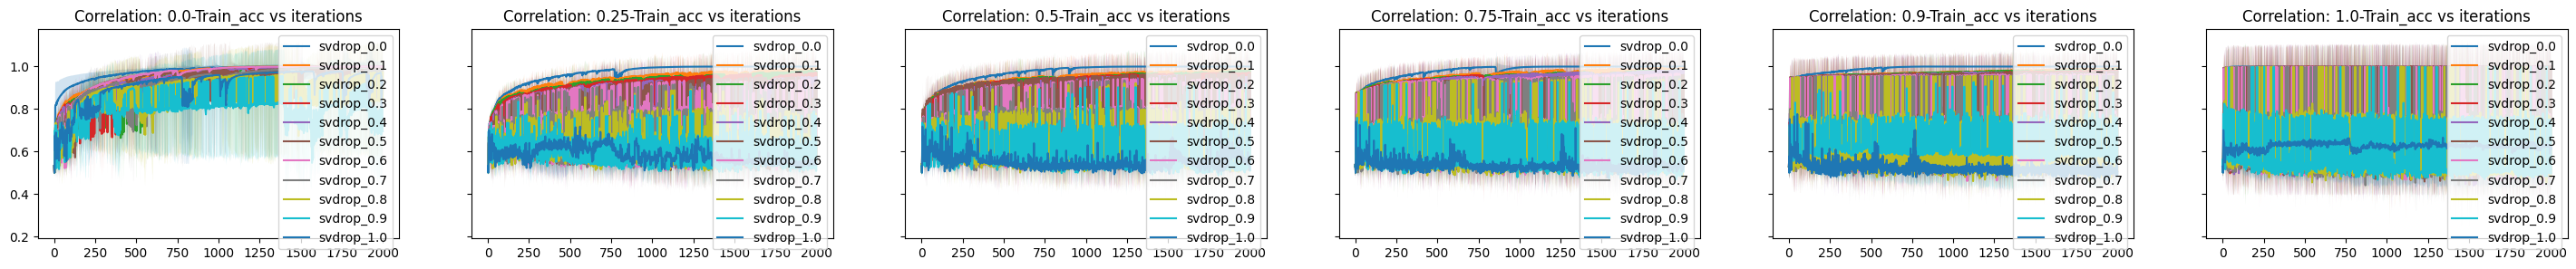

In [6]:
plot_metric(results, "mnistcifar", 'val_worst_group_acc')
plot_metric(results, "mnistcifar", 'val_acc')
plot_metric(results, "mnistcifar", 'val_best_group_acc')
plot_metric(results, "mnistcifar", 'train_worst_group_acc')
plot_metric(results, "mnistcifar", 'train_acc')

In [16]:
svdrop.groupby(['dataset','spur'])['val_worst_group_acc'].max().reset_index()

dataset  spur val_worst_group_acc
0  mnistcifar  0.00              93.53%
1  mnistcifar  0.25              90.89%
2  mnistcifar  0.50              86.52%
3  mnistcifar  0.75              79.08%
4  mnistcifar  0.90              58.99%
5  mnistcifar  1.00              55.34%

In [20]:
sv_max = svdrop.loc[svdrop.groupby(['dataset','spur'])['val_worst_group_acc'].idxmax()]
#print(sv_max.pivot(index="method",columns="spur",values=['val_worst_group_acc']))

In [13]:
pivot_df = svdrop.pivot(index='method', columns='spur', values=['val_acc','val_worst_group_acc'])
print(pivot_df)

           val_acc                                          \
spur          0.00    0.25    0.50    0.75    0.90    1.00   
method                                                       
svdrop_0.0  84.77%  93.80%  92.27%  87.70%  80.35%  59.05%   
svdrop_0.1  94.00%  94.10%  92.73%  89.50%  78.50%  65.90%   
svdrop_0.2  94.33%  94.00%  92.50%  88.25%  76.65%  67.40%   
svdrop_0.3  94.13%  93.43%  92.30%  86.30%  72.80%  65.80%   
svdrop_0.4  93.73%  92.77%  91.17%  86.80%  72.00%  69.50%   
svdrop_0.5  93.90%  92.67%  80.67%  82.75%  73.00%  66.90%   
svdrop_0.6  93.77%  91.70%  89.30%  83.80%  73.00%  68.00%   
svdrop_0.7  94.13%  90.80%  88.83%  80.75%  73.45%  69.95%   
svdrop_0.8  92.67%  86.43%  86.57%  77.50%  72.15%  68.95%   
svdrop_0.9  92.40%  86.23%  86.20%  74.35%  74.55%  64.70%   
svdrop_1.0  92.93%  72.73%  71.15%  72.35%  67.65%  66.83%   

           val_worst_group_acc                                          
spur                      0.00    0.25    0.50    0.75    

In [68]:
indices = df.groupby(['dataset','spur'])['val_worst_group_acc'].idxmax()
dfr = df.loc[indices]

## Singular Values Analysis

In [84]:

results_folder = "stats" # Where to get stats from
file_content = dict()
#methods = #['gdro',"rw", "erm"]
datasets = ['mnistcifar']

# Get all datafiles
for f in listdir(results_folder):
    a  = torch.load(join(results_folder,f))
    a = flatten_dict(a)
    file_content[f] = a

result = dict()
for method in ["svdrop_0.1"]:
    result[method] = dict()
    for dataset in datasets:
        result[method][dataset] = dict()
        for spur in [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]:
            data = get_data(file_content, method,dataset,spur)
            result[method][dataset][spur] = data

    for method in methods:
        f_result[method] = dict()
        for dataset in datasets:
            f_result[method][dataset] = dict()
            for spur in [0.0, 0.25, 0.5, 0.75, 0.9, 1.0]:
                f_result[method][dataset][spur] = group_data(result[method][dataset][spur])

In [96]:
len(result['svdrop_0.1']['mnistcifar'][0.5][0]['singular'])

2001

In [ ]:
total_pv[total_pv.index.isin(['erm',"erm_ft_100","erm_ft_1000",'rw',"gdro",'svdrop_0.1'])]

[tensor(30.7977), tensor(33.1863), tensor(36.4127), tensor(38.9031), tensor(40.9776), tensor(42.5963)]
[tensor(21.3012), tensor(22.6787), tensor(24.6683), tensor(25.5718), tensor(25.2403), tensor(24.3346)]
[tensor(14.7796), tensor(15.6193), tensor(16.9410), tensor(17.4852), tensor(18.3695), tensor(19.3658)]
[tensor(14.5347), tensor(14.7948), tensor(15.9499), tensor(17.1569), tensor(17.3337), tensor(17.8987)]
[tensor(14.0068), tensor(14.1851), tensor(14.9016), tensor(15.8534), tensor(16.5765), tensor(16.4850)]


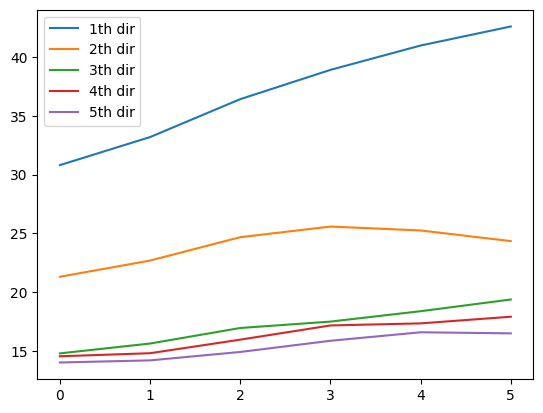

In [41]:
import matplotlib.pyplot as plt
top_k = 5
results = [[] for i in range(top_k)]
for r in result['svdrop']['mnistcifar'][0.9][0]['singular']:
    for i in range(top_k):
        results[i].append(r[i])

for i, r in enumerate(results):
    print(r)
    plt.plot(list(range(len(r))),r, label=f"{i+1}th dir")
    plt.legend()

In [32]:
total_pv.index

Index(['erm', 'erm_ft_10', 'erm_ft_100', 'erm_ft_1000', 'erm_ft_200',
       'erm_ft_50', 'erm_ft_500', 'gdro', 'imgnet_FT', 'rw', 'svdrop',
       'svdrop_0.0', 'svdrop_0.1', 'svdrop_0.2', 'svdrop_0.3', 'svdrop_0.4',
       'svdrop_0.5', 'svdrop_0.6', 'svdrop_0.7', 'svdrop_0.8', 'svdrop_0.9',
       'svdrop_1.0'],
      dtype='object', name='method')

In [41]:
total

method     dataset  spur val_acc val_worst_group_acc
0            rw  mnistcifar  0.00  93.51%              92.21%
1            rw  mnistcifar  0.25  92.67%              91.04%
2            rw  mnistcifar  0.50  92.39%              89.18%
3            rw  mnistcifar  0.75  90.38%              86.17%
4            rw  mnistcifar  0.90  88.25%              82.56%
5            rw  mnistcifar  1.00  58.19%               0.39%
6     imgnet_FT  mnistcifar  0.00  87.08%              85.19%
7     imgnet_FT  mnistcifar  0.25  85.69%              81.70%
8     imgnet_FT  mnistcifar  0.50  78.36%              72.46%
9     imgnet_FT  mnistcifar  0.75  66.89%              61.60%
10    imgnet_FT  mnistcifar  0.90  48.81%              44.67%
11    imgnet_FT  mnistcifar  1.00  47.92%              29.59%
12       svdrop  mnistcifar  0.00  93.00%              92.03%
13       svdrop  mnistcifar  0.25  73.07%              58.76%
14       svdrop  mnistcifar  0.50  72.13%              52.97%
15       svdrop  mnistcifar  0.75  68.47%              52.87%
16       svdrop  mnistcifar  0.90  66.77%              51.88%
17       svdrop  mnistcifar  1.00  62.23%              53.75%
18          erm  mnistcifar  0.00  93.57%              92.22%
19          erm  mnistcifar  0.25  93.37%              90.06%
20          erm  mnistcifar  0.50  91.67%              84.92%
21          erm  mnistcifar  0.75  88.10%              75.69%
22          erm  mnistcifar  0.90  79.44%              57.89%
23          erm  mnistcifar  1.00  56.87%               0.36%
24         gdro  mnistcifar  0.00  93.30%              92.38%
25         gdro  mnistcifar  0.25  92.98%              89.48%
26         gdro  mnistcifar  0.50  91.22%              84.47%
27         gdro  mnistcifar  0.75  87.73%              75.83%
28         gdro  mnistcifar  0.90  78.92%              56.50%
29         gdro  mnistcifar  1.00  51.40%               0.33%
0     erm_ft_10  mnistcifar  0.00  85.81%              72.75%
1     erm_ft_10  mnistcifar  0.25  82.96%              67.02%
2     erm_ft_10  mnistcifar  0.50  83.47%              63.52%
3     erm_ft_10  mnistcifar  0.75  81.32%              60.24%
4     erm_ft_10  mnistcifar  0.90  79.16%              58.91%
5     erm_ft_10  mnistcifar  1.00  64.91%              34.26%
6     erm_ft_50  mnistcifar  0.00  87.97%              79.54%
7     erm_ft_50  mnistcifar  0.25  88.56%              81.26%
8     erm_ft_50  mnistcifar  0.50  86.92%              73.14%
9     erm_ft_50  mnistcifar  0.75  85.23%              70.61%
10    erm_ft_50  mnistcifar  0.90  82.95%              63.59%
11    erm_ft_50  mnistcifar  1.00  69.13%              49.54%
12   erm_ft_100  mnistcifar  0.00  89.17%              84.67%
13   erm_ft_100  mnistcifar  0.25  87.37%              80.77%
14   erm_ft_100  mnistcifar  0.50  88.71%              80.30%
15   erm_ft_100  mnistcifar  0.75  85.15%              69.63%
16   erm_ft_100  mnistcifar  0.90  82.90%              61.48%
17   erm_ft_100  mnistcifar  1.00  68.91%              48.35%
18   erm_ft_200  mnistcifar  0.00  89.64%              86.51%
19   erm_ft_200  mnistcifar  0.25  88.71%              84.54%
20   erm_ft_200  mnistcifar  0.50  87.90%              79.55%
21   erm_ft_200  mnistcifar  0.75  84.52%              71.14%
22   erm_ft_200  mnistcifar  0.90  83.51%              67.58%
23   erm_ft_200  mnistcifar  1.00  68.66%              47.86%
24   erm_ft_500  mnistcifar  0.00  91.17%              89.26%
25   erm_ft_500  mnistcifar  0.25  89.76%              87.11%
26   erm_ft_500  mnistcifar  0.50  88.63%              81.18%
27   erm_ft_500  mnistcifar  0.75  87.71%              78.25%
28   erm_ft_500  mnistcifar  0.90  85.14%              73.12%
29   erm_ft_500  mnistcifar  1.00  70.11%              55.45%
30  erm_ft_1000  mnistcifar  0.00  91.32%              89.88%
31  erm_ft_1000  mnistcifar  0.25  90.37%              87.37%
32  erm_ft_1000  mnistcifar  0.50  89.60%              82.65%
33  erm_ft_1000  mnistcifar  0.75  86.20%

In [40]:
# Set the maximum number of rows and columns to display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)